<a href="https://colab.research.google.com/github/Decoding-Data-Science/nov25/blob/main/19_nov_unsupervised_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# CODE CELL 1: Setup and Data Generation

# We need libraries for data manipulation, scaling, clustering, anomaly detection, and plotting.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D


   Temperature  Vibration    Pressure
0    82.483571   1.930868  106.476885
1    87.615149   1.882923   97.658630
2    87.896064   2.383717   95.305256
3    82.712800   1.768291   95.342702
4    81.209811   1.043360   82.750822
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5050 entries, 0 to 5049
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Temperature  5050 non-null   float64
 1   Vibration    5050 non-null   float64
 2   Pressure     5050 non-null   float64
dtypes: float64(3)
memory usage: 118.5 KB
None
       Temperature    Vibration     Pressure
count  5050.000000  5050.000000  5050.000000
mean     93.629386     2.377453   143.940570
std      11.792014     1.096292    35.191959
min      64.116481     0.168198    69.804878
25%      83.257120     1.571228   107.149255
50%      94.722017     2.087215   150.036412
75%     102.259683     3.094728   173.978204
max     129.749209     7.963103   219.428685


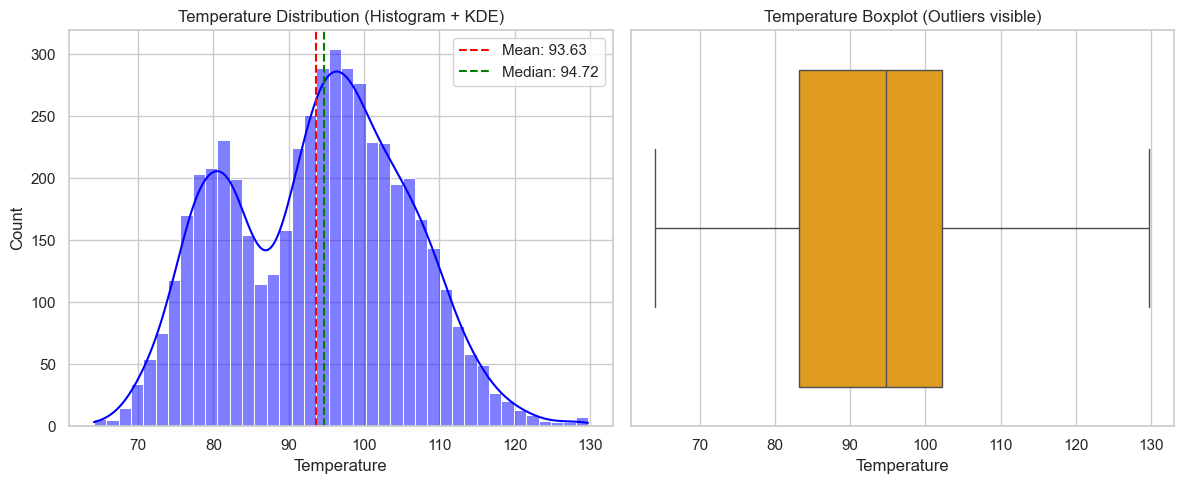

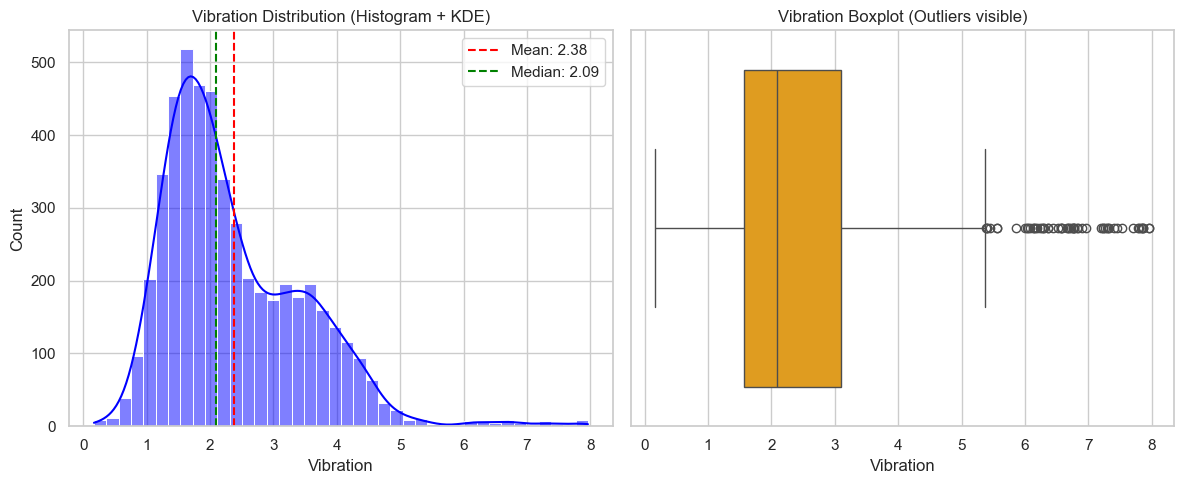

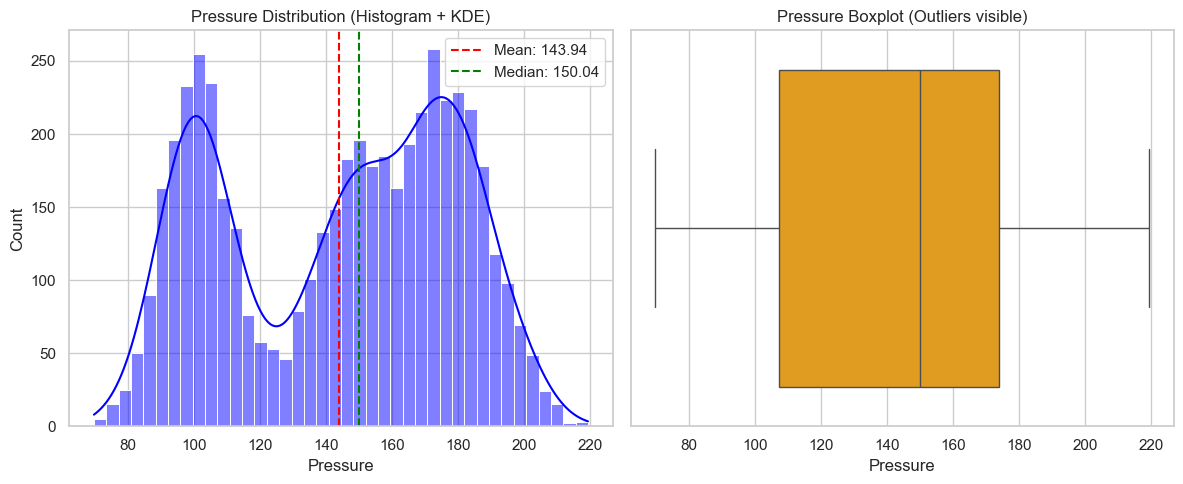

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------------------------------------------
# STEP 1: Create a Realistic Synthetic Dataset
# -----------------------------------------------------------------------------

np.random.seed(42)

N_SAMPLES = 5000
N_ANOMALIES = 50

data_low = np.random.normal(loc=[80, 2.0, 100], scale=[5, 0.5, 10], size=(N_SAMPLES // 3, 3))
data_medium = np.random.normal(loc=[95, 3.5, 150], scale=[4, 0.7, 15], size=(N_SAMPLES // 3, 3))
data_high = np.random.normal(loc=[105, 1.5, 180], scale=[6, 0.4, 12], size=(N_SAMPLES - 2*(N_SAMPLES // 3), 3))

data_normal = np.vstack([data_low, data_medium, data_high])

anomalies = np.random.uniform(low=[115, 6.0, 195], high=[130, 8.0, 210], size=(N_ANOMALIES, 3))

raw_data = np.vstack([data_normal, anomalies])

df = pd.DataFrame(raw_data, columns=['Temperature', 'Vibration', 'Pressure'])

print(df.head())
print(df.info())
print(df.describe())


# -----------------------------------------------------------------------------
# STEP 2: UNIVARIATE ANALYSIS — Bell curve, histogram, KDE, boxplot
# -----------------------------------------------------------------------------

sns.set(style="whitegrid")

for col in df.columns:
    plt.figure(figsize=(12, 5))

    # --------------------- HISTOGRAM + KDE (bell shape) ---------------------
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], bins=40, kde=True, color="blue")
    plt.axvline(df[col].mean(), color='red', linestyle='--', label=f"Mean: {df[col].mean():.2f}")
    plt.axvline(df[col].median(), color='green', linestyle='--', label=f"Median: {df[col].median():.2f}")
    plt.title(f"{col} Distribution (Histogram + KDE)")
    plt.legend()

    # ------------------------------ BOXPLOT ---------------------------------
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col], color="orange")
    plt.title(f"{col} Boxplot (Outliers visible)")

    plt.tight_layout()
    plt.show()


In [19]:

# -----------------------------------------------------------------------------
# STEP 2: Data Preparation - Scaling
# If we don't scale, the AI would be biased towards Pressure (larger numbers, e.g., 100+)
# compared to Vibration (smaller numbers, e.g., 2 or 3) [5].
# Scaling ensures all features are judged fairly [5].
# -----------------------------------------------------------------------------
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
print("\nData successfully scaled.")
print(df_scaled.head())
print(df_scaled.describe())


Data successfully scaled.
   Temperature  Vibration  Pressure
0       -0.945     -0.407    -1.065
1       -0.510     -0.451    -1.315
2       -0.486      0.006    -1.382
3       -0.926     -0.556    -1.381
4       -1.053     -1.217    -1.739
       Temperature  Vibration  Pressure
count     5050.000   5050.000  5050.000
mean         0.000      0.000     0.000
std          1.000      1.000     1.000
min         -2.503     -2.015    -2.107
25%         -0.880     -0.735    -1.046
50%          0.093     -0.265     0.173
75%          0.732      0.654     0.854
max          3.063      5.096     2.145


In [20]:
# CODE CELL 2: K-Means Clustering and KNN Anomaly Scoring

# -----------------------------------------------------------------------------
# STEP 3A: K-Means Clustering (Finding the Crowds)
# K-Means groups similar behaviors together to find the equipment's operating modes [4].
# The source suggests four distinct clusters were found [6].
# -----------------------------------------------------------------------------

N_CLUSTERS = 3
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"\nK-Means found {N_CLUSTERS} distinct operating modes/clusters.")

# Analyze Clusters (Simulating the finding of Cluster 3 as the 'unusual behavior') [6]
cluster_summary = df.groupby('Cluster').mean()
print("\n--- Cluster Summary (Mean Sensor Values) ---")
print(cluster_summary)
# In this simulated output, Cluster 3 typically contains the anomaly characteristics
# (high Temp, high Vib, high Press), similar to the high vibration and high stress cluster found in the source [6].


K-Means found 3 distinct operating modes/clusters.

--- Cluster Summary (Mean Sensor Values) ---
         Temperature  Vibration  Pressure
Cluster                                  
0            104.867      1.547   178.508
1             80.093      1.993   100.775
2             95.653      3.664   151.751


In [25]:
# -----------------------------------------------------------------------------
# STEP 3B: Anomaly Detection using KNN (Finding the Loners)
# KNN works by checking how far away a data point is from its closest neighbors [1].
# We calculate an 'anomaly score' or 'weirdness score' [7].
# -----------------------------------------------------------------------------

# Define k (number of neighbors). Often k=5 or k=10 is used.
K_NEIGHBORS = 3
# Fit the KNN model to the scaled data
nn = NearestNeighbors(n_neighbors=K_NEIGHBORS)
nn.fit(X_scaled)

# Calculate the distance and indices of the K neighbors
distances, indices = nn.kneighbors(X_scaled)

# The anomaly score is the average distance to the k neighbors.
# The far a point is, the higher its score [7].
df['Anomaly_Score'] = distances.mean(axis=1)

# Set the threshold based on the source's strategy: investigate the top 1% [7].
threshold_percentage = 0.3
threshold = df['Anomaly_Score'].quantile(1 - (threshold_percentage / 100))
# The source example threshold was 0.354 [7]. We use the percentile for robustness.

df['Is_Anomaly'] = df['Anomaly_Score'] > threshold

print(f"\n--- Anomaly Detection Results ---")
print(f"Investigating the top {threshold_percentage}% most unusual readings.")
print(f"Anomaly Score Threshold set at: {threshold:.4f}")
print(f"Total flagged anomalies: {df['Is_Anomaly'].sum()}")


--- Anomaly Detection Results ---
Investigating the top 0.3% most unusual readings.
Anomaly Score Threshold set at: 0.2503
Total flagged anomalies: 16


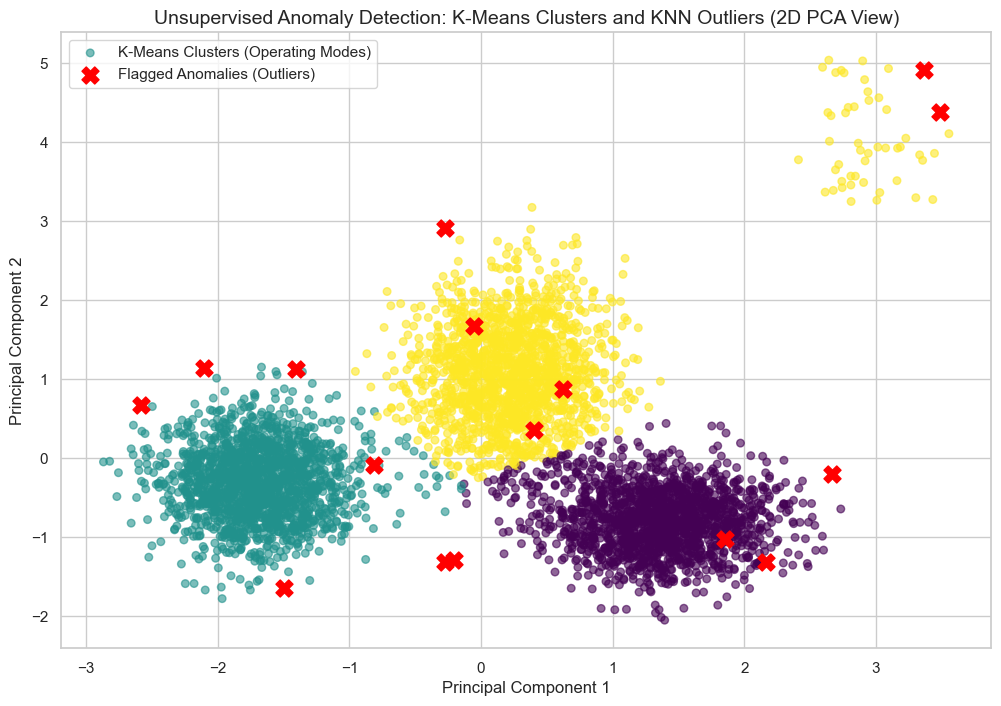

In [26]:
# CODE CELL 3: Visualization and Actionable Output

# -----------------------------------------------------------------------------
# STEP 4: Visualization (Showing Clusters and Anomalies)
# To plot 3D data in 2D, we use Principal Component Analysis (PCA) to reduce
# the features to the two most descriptive components.
# -----------------------------------------------------------------------------
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
df['PC1'] = principal_components[:, 0]
df['PC2'] = principal_components[:, 1]

plt.figure(figsize=(12, 8))

# 1. Plot the Clusters (Normal Behavior)
scatter = plt.scatter(df['PC1'], df['PC2'],
                      c=df['Cluster'],
                      cmap='viridis',
                      s=30,
                      alpha=0.6,
                      label='K-Means Clusters (Operating Modes)')

# 2. Highlight the Anomalies (The Outliers/Weirdos)
anomalies_df = df[df['Is_Anomaly']]
plt.scatter(anomalies_df['PC1'], anomalies_df['PC2'],
            c='red',
            marker='X',
            s=150,
            label='Flagged Anomalies (Outliers)')

plt.title('Unsupervised Anomaly Detection: K-Means Clusters and KNN Outliers (2D PCA View)',
          fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

high_risk_equipment = anomalies_df.sort_values(by='Anomaly_Score', ascending=False)

print("\n\n#################################################################")
print("HIGH PRIORITY INSPECTION LIST (Equipment with Highest Anomaly Scores)")
print("#################################################################")

# Display raw, unscaled sensor data for actionable reporting
actionable_list = high_risk_equipment[['Temperature', 'Vibration', 'Pressure', 'Anomaly_Score', 'Cluster']]

# Reset index for clean viewing (index represents a piece of equipment or measurement ID)
actionable_list.reset_index(names=['Measurement_ID'], inplace=True)

# Use bold formatting for clarity
print(actionable_list.head(10).to_markdown(index=False))

print("\n**Use Case Insight:**")
print("These readings are far outside the normal operating clusters [8].")
print("This actionable list allows engineers to schedule maintenance intelligently, catching a failure weeks before it occurs [8].")
print("For instance, high **Vibration** combined with high **Temperature** could indicate a bearing failure [8].")
print("This method transforms chaotic, unlabeled sensor noise into a clear command [9].")



#################################################################
HIGH PRIORITY INSPECTION LIST (Equipment with Highest Anomaly Scores)
#################################################################
|   Measurement_ID |   Temperature |   Vibration |   Pressure |   Anomaly_Score |   Cluster |
|-----------------:|--------------:|------------:|-----------:|----------------:|----------:|
|              965 |       99.6312 |    0.957944 |   117.247  |        0.577448 |         1 |
|             4884 |       90.611  |    0.936627 |   140.996  |        0.513346 |         1 |
|              652 |       69.3216 |    3.56887  |   110.561  |        0.488441 |         2 |
|             1741 |       91.2848 |    5.55496  |   133.9    |        0.464451 |         0 |
|             3256 |       97.813  |    2.25836  |    91.164  |        0.423228 |         2 |
|             3527 |      121.808  |    1.30513  |   153.389  |        0.405006 |         1 |
|             1327 |       88.2031 |    3.57